Imports

In [1]:
import feed_forward
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import geoopt
from time import time
from torchvision import datasets, transforms
import helper
torch.cuda.is_available()

True

CUDA check

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Data Transformation

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Normalize((0.1307,), (0.3081,)), 
                              ])

Training and Test data from MNIST data set

In [4]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=512, shuffle=True)

C:\Users\julia\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Initializing the model

In [5]:
model = feed_forward.HypFF(784, 512, 256, 10)
model.to(device)

HypFF(
  (fc1): MobLinear(
    in_features=784, out_features=512, bias=True
    (ball): PoincareBall manifold
  )
  (fc2): MobLinear(
    in_features=512, out_features=256, bias=True
    (ball): PoincareBall manifold
  )
  (fc3): MobLinear(
    in_features=256, out_features=10, bias=True
    (ball): PoincareBall manifold
  )
)

In [6]:
print(model)

HypFF(
  (fc1): MobLinear(
    in_features=784, out_features=512, bias=True
    (ball): PoincareBall manifold
  )
  (fc2): MobLinear(
    in_features=512, out_features=256, bias=True
    (ball): PoincareBall manifold
  )
  (fc3): MobLinear(
    in_features=256, out_features=10, bias=True
    (ball): PoincareBall manifold
  )
)


Hyperparameters

In [7]:
#learning_rate = 8e-1 
learning_rate = 2e-1 #learning rate for ReLU activation function
#learning_rate = 2e-1 #current learning rate for model without activation functions
momentum = 0.9

Loss Function

In [8]:
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images, labels = images.to(device), labels.to(device)
images = 0.0357*images.view(images.shape[0], -1)
print(images)

out = model(images) #output
print(out)
loss = criterion(out, labels) #calculate the loss

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
tensor([[-0.0680, -0.0206,  0.0263,  ...,  0.0302, -0.0093,  0.0215],
        [-0.0706, -0.0261,  0.0266,  ...,  0.0307, -0.0121,  0.0214],
        [-0.0706, -0.0228,  0.0262,  ...,  0.0321, -0.0109,  0.0207],
        ...,
        [-0.0688, -0.0229,  0.0257,  ...,  0.0305, -0.0100,  0.0190],
        [-0.0685, -0.0248,  0.0284,  ...,  0.0303, -0.0095,  0.0186],
        [-0.0698, -0.0266,  0.0276,  ...,  0.0296, -0.0100,  0.0193]],
       device='cuda:0', grad_fn=<SWhereBackward>)


Optimizer

In [9]:
optimizer = geoopt.optim.RiemannianSGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [10]:

time0 = time()

epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        # Flatten MNIST images into a 784 long vector
        images = 0.0357*images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #backpropagation
        loss.backward()
        
        #Weight optimization
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 2.01911231925932
Epoch 1 - Training loss: 1.5613729610281475
Epoch 2 - Training loss: 1.4971031556695193
Epoch 3 - Training loss: 1.4741728265406722
Epoch 4 - Training loss: 1.4612262350017742
Epoch 5 - Training loss: 1.4534148856744928
Epoch 6 - Training loss: 1.4483806935407348
Epoch 7 - Training loss: 1.4435009259288594
Epoch 8 - Training loss: 1.4401785509061005
Epoch 9 - Training loss: 1.4379993656934318

Training Time (in minutes) = 2.5551495512326556


tensor([[-0.1094, -0.0940, -0.0542,  0.9443, -0.1202, -0.0414, -0.1108, -0.1636,
         -0.1393, -0.0454]])
[-0.1093894, -0.093996905, -0.054213755, 0.94425666, -0.12015557, -0.041376367, -0.11081646, -0.1636233, -0.13925606, -0.04539017]
Predicted Digit = 3


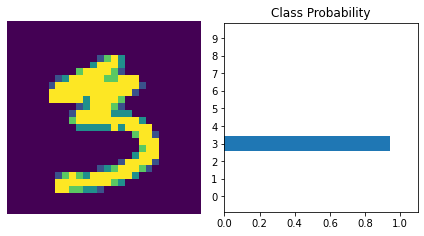

In [26]:
images, labels = next(iter(valloader))
#images, labels = images.to(device), labels.to(device)

img = 0.0357*images[0].view(1, 784)
img_gpu = img.to(device)
with torch.no_grad():
    out = model(img_gpu)

ps = out.cpu()
print(ps)
probab = list(ps.numpy()[0])
print(probab)
print("Predicted Digit =", probab.index(max(probab)))
helper.view_classify(img.view(1, 28, 28), ps)

In [12]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  images, labels = images.to(device), labels.to(device)
  for i in range(len(labels)):
    img = 0.0357*images[i].view(1, 784)
    with torch.no_grad():
        out = model(img)

    
    ps = out.cpu()
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu().numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.98


Current status of experiments:
1. Using just Hyperboic Linear modules, and with the appropriate self-tuned hyperparameters, and a batch size of 512, the average accuracy was around 90 percent
2. With the use of activation functions(ReLu, ReLu, then LogSoftMax at the output layer), (by applying the functions in the tangent space, then mapping it back to the hyperbolic space), we see an increase in the model accuracy to about 97-98 percent.
3. To account for the correct class probabilities , linear layer was used as the output layer instead, together with the crossentropy loss function.